In [1]:
%matplotlib inline
datadir='/l/necadam1/AaroBEC_data'
import qpms
from qpms import Particle, CTMatrix, BaseSpec, FinitePointGroup, ScatteringSystem, TMatrixGenerator, dbgmsg_enable, dbgmsg_disable, dbgmsg_active, BesselType, EpsMu, EpsMuGenerator, lorentz_drude, ScatteringSystemCachingMode
from qpms import eV, hbar, c
from qpms.symmetries import point_group_info
import numpy as np
import time
import re
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
eh = eV/hbar
import os
import glob

def ri(z): return (z.real, z.imag)
#m = re.compile(r"([^_]+)_r([0-9.]+)nm_")
removeir = re.compile(r"_ir[^.]+.npz")
eh = eV/hbar

def iriclass(ss, fullvec):
    fullnorm = np.linalg.norm(fullvec)
    return [np.linalg.norm(ss.pack_vector(fullvec, iri))/fullnorm for iri in range(ss.nirreps)]

os.chdir(datadir)

In [47]:
def finiterectlat_scatsystem_rebuild(meta, make_posthing=True):
    Nx, Ny = meta['size']
    px, py = meta['period']
    
    #Particle positions
    orig_x = (np.arange(Nx/2) + (0 if (Nx % 2) else .5)) * px
    orig_y = (np.arange(Ny/2) + (0 if (Ny % 2) else .5)) * py

    orig_xy = np.stack(np.meshgrid(orig_x, orig_y), axis = -1)


    bspec = BaseSpec(lMax = meta['lMax'])
    medium = EpsMuGenerator(EpsMu(meta['refractive_index']**2)) 
    material = meta['material']
    if material in lorentz_drude.keys():
        foreground_emg=EpsMuGenerator(lorentz_drude[material])
    else:
        try: lemat = float(material)
        except ValueError:
            try: lemat = complex(material)
            except ValueError as ve:
                raise ValueError("--material must be either a label such as 'Ag', 'Au', or a number") from ve
        material = lemat
        foreground_emg = EpsMuGenerator(EpsMu(material**2))

    if meta['height'] is None:
        tmgen = TMatrixGenerator.sphere(medium, foreground_emg, meta['radius'])
    else:
        tmgen = TMatrixGenerator.cylinder(medium, foreground_emg, meta['radius'], meta['height'], lMax_extend = meta['lMax_extend'])

    particles= [Particle(orig_xy[i], tmgen, bspec) for i in np.ndindex(orig_xy.shape[:-1])]

    sym = FinitePointGroup(point_group_info['D2h'])
    ss, ssw = ScatteringSystem.create(particles, medium, sym, meta['centre'] * eh)
    
    if make_posthing:
        nelem = len(bspec)
        positions = ss.positions
        xpositions = np.unique(positions[:,0])
        assert(len(xpositions) == Nx)
        ypositions = np.unique(positions[:,1])
        assert(len(ypositions == Ny))
        # particle positions as integer indices
        posmap = np.empty((positions.shape[0],2), dtype=int)
        for i, pos in enumerate(positions):
            posmap[i,0] = np.searchsorted(xpositions, positions[i,0])
            posmap[i,1] = np.searchsorted(ypositions, positions[i,1])
        return (ss, bspec, Nx, Ny, px, py, posmap,)
    else:
        return ss
    
def fullvec2grid(posthing, fullvec):
    ss, bspec, Nx, Ny, px, py, posmap = posthing
    nelem = len(bspec)
    arr = np.empty((Nx,Ny,nelem), dtype=complex)
    for pi, offset in enumerate(ss.fullvec_poffsets):
        ix, iy = posmap[pi]
        arr[ix, iy] = fullvec[offset:offset+nelem]
    return arr
    

In [48]:
allfiles=glob.glob('cyl*cn*_ir*.npz')
allgraphs=dict()
for f in allfiles:
    base = removeir.sub('', f)
    if base in allgraphs.keys():
        allgraphs[base] += 1
    else:
        allgraphs[base] = 1
for k in sorted(allgraphs.keys()):
    print(k.encode('utf-8', 'surrogateescape').decode('utf-8'), allgraphs[k])

cyl_r50nm_h50nm_p570nmx620nm_10x10_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn1000 8
cyl_r50nm_h50nm_p570nmx620nm_10x10_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn150 1
cyl_r50nm_h50nm_p570nmx620nm_10x10_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn2000 8
cyl_r50nm_h50nm_p570nmx620nm_10x10_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn500 8
cyl_r50nm_h50nm_p570nmx620nm_10x10_mAu_n1.52_L2_c((1.431028+0j)±0.05±0.05j)eV_cn150 1
cyl_r50nm_h50nm_p570nmx620nm_17x13_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn500 8
cyl_r50nm_h50nm_p570nmx620nm_17x13_mAu_n1.52_L2_c((1.431027-0.05j)±0.1±0.1j)eV_cn1500 8
cyl_r50nm_h50nm_p570nmx620nm_20x20_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn1000 8
cyl_r50nm_h50nm_p570nmx620nm_20x20_mAu_n1.52_L3_c((1.431027+0j)±0.05±0.05j)eV_cn1000 8
cyl_r50nm_h50nm_p570nmx620nm_25x25_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn1000 8
cyl_r50nm_h50nm_p570nmx620nm_30x30_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn1000 8
cyl_r50nm_h50nm_p570nmx620nm_5x5_mAu_n1.52_L2_

In [49]:
filenames=sorted(glob.glob('cyl_*17x13*L2*cn1500*.npz'))
plotdata = {}
print(len(filenames))

8


In [50]:
file = filenames[0]
dat = np.load(file, allow_pickle=True)
meta=dat['meta'][()]
basicdata0=(meta['lMax'], tuple(meta['size'])) # this will be checked along
posthing = finiterectlat_scatsystem_rebuild(meta)
ss, bspec, Nx, Ny, px, py, _  = posthing
nelem = len(bspec)

In [123]:
res_thr = 1e-2

plotrecords = [None]*ss.nirreps

for file in filenames:
    dat = np.load(file, allow_pickle=True)
    meta = dat['meta'][()]
    assert(basicdata0==(meta['lMax'], tuple(meta['size'])))
    iri = dat['iri']
    valid = dat['residuals'] < res_thr
    iris.extend([iri]*sum(valid))
    eigvalv=dat['eigval'][valid]
    eigvecv=dat['eigvec'][valid]
    residv =dat['residuals'][valid]
    plotrecords_iri = []
    for i, eigval in enumerate(eigvalv):
        fulvec_beyn=ss.unpack_vector(eigvecv[i],iri)
        vecgrid = fullvec2grid(posthing,fulvec_beyn)
        vecgrid_ff = np.fft.fft2(vecgrid, axes=(0,1))

        # try to determine k-vector
        ysum = np.sum(abs(vecgrid_ff), axis=(1,2))
        xsum = np.sum(abs(vecgrid_ff), axis=(0,2))
        kxmax = np.amax(ysum)
        kymax = np.amax(xsum)
        kxidx = np.arange(Nx)[np.isclose(kxmax, ysum)]
        kyidx = np.arange(Ny)[np.isclose(kymax, xsum)]
        # we want it symmetric around zero, not N/2
        kxidx[kxidx > Nx / 2] -= Nx
        kyidx[kyidx > Ny / 2] -= Ny
        kx = kxidx * 2 * np.pi / Nx / px
        ky = kyidx * 2 * np.pi / Ny / py
        plotrecords_iri.append((eigval, residv[i], kx, ky))
    plotrecords[iri] = plotrecords_iri
        
    print(iri, sum(valid), "%g"%dat['ranktest_SV'][0])
    
markerdict = {
    0: "3",
    1: "4",
    2: "^",
    3: "v",
    4: 'x',
    5: '+',
    6: 's',
    7: 'd',
}

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colordict = {i: colors[i] for i in range(8)}

def markerfun(b):
    b=int(b)
    if b in markerdict.keys():
        return markerdict[b]
    else: return 'X'

def colorfun(b):
    if (b+1) in colordict.keys():
        return colordict[b+1]
    else: return colordict[0]

0 37 3.34724e+17
1 26 2.66057e+17
2 42 3.554e+17
3 36 6.02979e+17
4 39 2.23386e+17
5 27 6.19465e+17
6 43 2.3515e+17
7 33 3.00728e+17


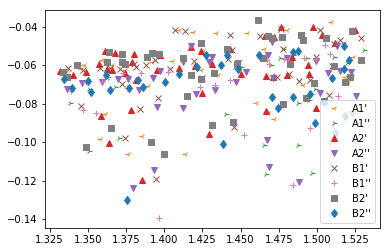

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111)
for iri, records_iri in enumerate(plotrecords):
    eigval, residv, kx, ky = zip(*records_iri)
    eigval_r = [e.real/eh for e in eigval]
    eigval_i = [e.imag/eh for e in eigval]
    ax.plot(eigval_r, eigval_i, marker= markerfun(iri), color=colorfun(iri), ls='', label=ss.irrep_names[iri])
ax.legend() ;

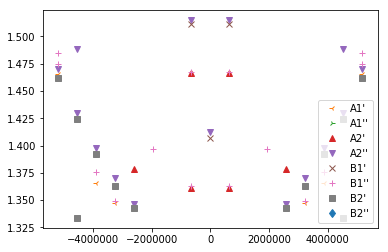

In [121]:
fig = plt.figure()
ax = fig.add_subplot(111)
for iri, records_iri in enumerate(plotrecords):
    eigval_rs = []
    kxs = []
    for rec in records_iri:      
        eigval, residv, kx, ky = rec
        if(np.all(ky==0)):
            eigval_r = eigval.real/eh
            for kx_ in kx:
                kxs.append(kx_)
                eigval_rs.append(eigval_r)

    ax.plot(kxs, eigval_rs, marker= markerfun(iri), color=colorfun(iri), ls='', label=ss.irrep_names[iri])
ax.legend(loc='lower right')

In [61]:
iri, freqi = 3, 0
eigval, eigvec = valid_eigs_iri[iri]
freq = eigval[freqi]
vec_beyn = eigvec[freqi]

In [62]:
print(freq/eh)
ssw = ss(freq)

(1.5226018795618195-0.08538819984195048j)


In [63]:
ImTW = ssw.modeproblem_matrix_packed(iri=iri)
U, S, Vh = np.linalg.svd(ImTW)
Vt = Vh.conj()
S[-5:]

array([1.80067323e-01, 1.36985094e-01, 7.67752266e-02, 4.23467329e-02, 1.16083697e-05])

In [64]:
vec_svd = Vt[-1]
fulvec_svd= ss.unpack_vector(vec_svd, iri)
fulvec_beyn=ss.unpack_vector(vec_beyn,iri)
np.linalg.norm((np.dot(ImTW,vec_svd))), np.linalg.norm((np.dot(ImTW,vec_beyn)))

(1.1608369702102272e-05, 0.0008174271722008524)

[ 1  4  6  8 10 11 15]
[ 1  4  6  8 10 11 15]


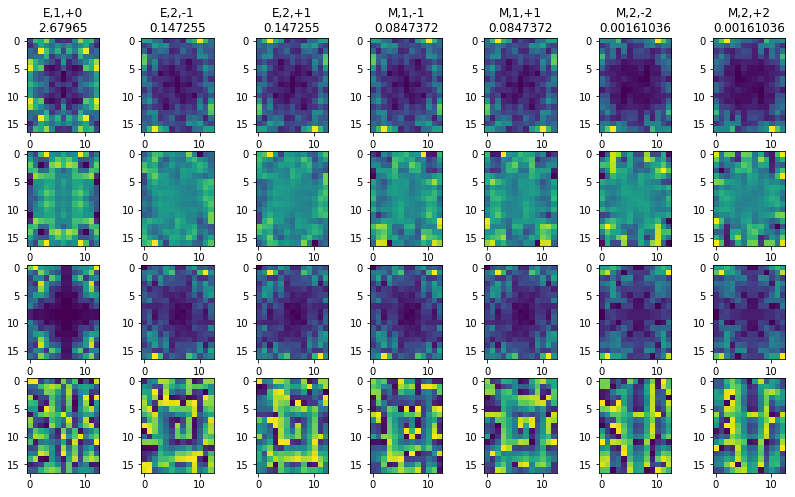

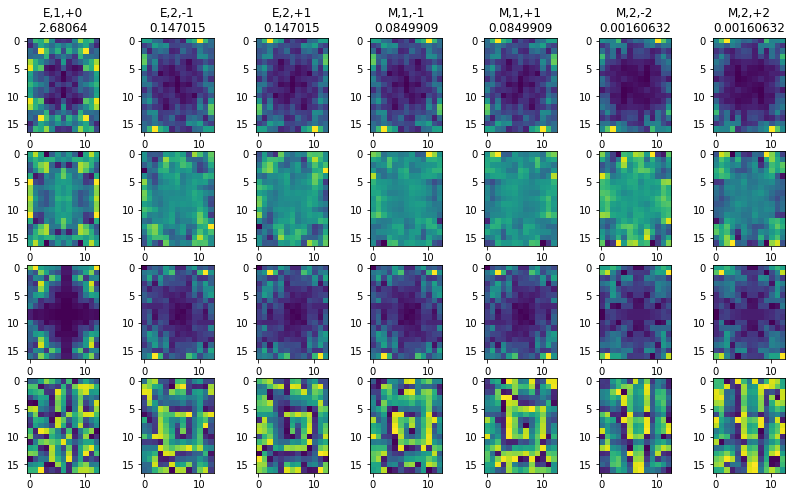

In [65]:
for fulvec in (fulvec_beyn, fulvec_svd,):
    vecgrid = fullvec2grid(posthing,fulvec)
    vecgrid_ff = np.fft.fft2(vecgrid, axes=(0,1))
    #print (np.amax(abs(vecgrid),axis=(0,1)))
    #print (np.amax(abs(vecgrid_ff),axis=(0,1)))
    vecgrid_ff_maxes = np.amax(abs(vecgrid_ff), axis=(0,1))
    relevant_y = np.arange(nelem)[vecgrid_ff_maxes > 1e-4]
    print(relevant_y)
    t, l, m = bspec.tlm()


    scale = 2
    f, axes = plt.subplots(4, len(relevant_y), figsize = (scale*len(relevant_y), scale*4))
    for i, y in enumerate(relevant_y):
        axes[0, i].set_title("%s,%d,%+d\n%g"%('E' if t[y]==2 else 'M', l[y], m[y], vecgrid_ff_maxes[y]))
        axes[0, i].imshow(abs(vecgrid[...,y]))
        #axes[1, i].imshow(np.angle(vecgrid[...,y]))
        axes[1, i].imshow(vecgrid[...,y].real)
        axes[2, i].imshow(abs(vecgrid_ff[...,y]))
        axes[3, i].imshow(np.angle(vecgrid_ff[...,y]))

In [66]:
vecgrid_ff_abs_xsum = np.sum(abs(vecgrid_ff), axis=(1,2))

In [68]:
# try to determine k-vector
ysum = np.sum(abs(vecgrid_ff), axis=(1,2))
xsum = np.sum(abs(vecgrid_ff), axis=(0,2))
kxmax = np.amax(ysum)
kymax = np.amax(xsum)
kxidx = np.arange(Nx)[np.isclose(kxmax, ysum)]
kyidx = np.arange(Ny)[np.isclose(kymax, xsum)]
# we want it symmetric around zero, not N/2
kxidx[kxidx > Nx / 2] -= Nx
kyidx[kyidx > Ny / 2] -= Ny
kx = kxidx * 2 * np.pi / Nx / px
ky = kyidx * 2 * np.pi / Ny / py
kx, ky

(array([0.]), array([ 1559103.05389072, -1559103.05389072]))